# Теория вероятностей. Домашнее задание 1

В этом домашнем задании мы построим собственный алгоритм классификации на основе вероятностой модели.

В файле `languages.zip` вы найдете коллекцию текстов на английском, итальянском, испанском, немецком, французском, польском и португальском языках, полученных из случайных статей Википедии. См., например, файл `Spanish.txt`. (В соответствующих файлах `*.sources.txt` указаны источники со ссылками.)

In [51]:
# загружаем данные
import urllib.request
urllib.request.urlretrieve("https://github.com/mariamath/learning_materials/raw/main/data/languages.zip"
                          ,"assets/ex_1/languages.zip")

('assets/ex_1/languages.zip', <http.client.HTTPMessage at 0x1f30de9ee00>)

In [52]:
# проверяем загрузку (наличие файла languages.zip)
import os
print(os.listdir("assets/ex_1"))

['.gitkeep', 'English.sources.txt', 'English.txt', 'French.sources.txt', 'French.txt', 'German.sources.txt', 'German.txt', 'Italian.sources.txt', 'Italian.txt', 'languages.zip', 'Polish.sources.txt', 'Polish.txt', 'Portuguese.sources.txt', 'Portuguese.txt', 'Spanish.sources.txt', 'Spanish.txt']


In [53]:
# разархивируем данные
import zipfile
zipfile.ZipFile("assets/ex_1/languages.zip", 'r').extractall("assets/ex_1")

In [54]:
with open("assets/ex_1/Spanish.txt", encoding='utf-8') as f:
    print(f.read(500))

tomas zapata sierra medellin colombia  de mayo de  es productor de cine y de teatrocita requerida
sad eyed lady of the lowlands en espanol senorita de ojos tristes de las tierras bajas es una cancion compuesta por el cantante estadounidense bob dylan fue incluida en el album blonde on blonde editado el  de mayo de 
la revista mojo la coloco en el puesto  de su lista de las  mejores canciones de bob dylan
calyptocephalella canqueli es una especie extinta de anfibio anuro perteneciente al genero c


In [55]:
with open("assets/ex_1/German.txt", encoding='utf-8') as f:
    print(f.read(500))

riedhofe ist der name von ortsteilen in deutschland

in badenwurttemberg
riedhofe langenau ortsteil der stadt langenau im albdonaukreis
riedhofe frickingen ortsteil der gemeinde frickingen im bodenseekreis
riedhofe riegel am kaiserstuhl ortsteil der gemeinde riegel am kaiserstuhl im landkreis emmendingen
riedhofe kongen ortsteil der gemeinde kongen im landkreis esslingen
riedhofe leingarten ortsteil der gemeinde leingarten im landkreis heilbronn
riedhofe bad wurzach ortsteil der stadt bad wurzac


## Визуализация облака слов (0.5 баллов)

Выберите ваш любимый язык из предложенных и визуализируйте самые частые слова из приведенных текстов на этом языке в виде облака слов, используя `WordCloud` из библиотеки `wordcloud`.

In [56]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

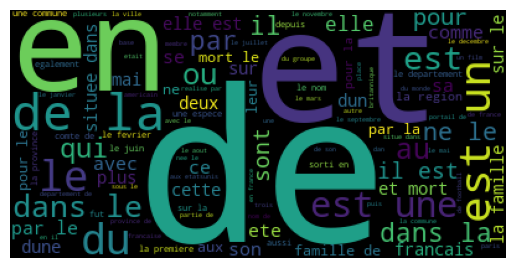

In [57]:
### Решение
with open("assets/ex_1/French.txt", encoding='utf-8') as f:
    text = f.read()


wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()    


## Предобработка данных

На данных из этих файлов мы будем обучать наш классификатор. Эти тексты уже предобработаны: оставлены только стандартные латинские символы, удалены диакритические знаки, убраны знаки препинания, все буквы преобразованы в нижний регистр.
Мы будем использовать аналогичную предварительную обработку для новых текстов, которые нам нужно классифицировать. Давайте посмотрим на некоторые полезные функции для этого.

In [58]:
import re
import unicodedata


def strip_accents(s):
    s = s.lower()
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def clean_text(s):
    return re.sub("[^a-z \n]", "", strip_accents(s))

Давайте проверим, что получится, если мы применим нашу функцию:

In [59]:
sample_text = "Café con leche!"
cleaned_text = clean_text(sample_text)
print(cleaned_text)

cafe con leche


In [60]:
sample_text2 = "Übung Nummer fünf"
cleaned_text2 = clean_text(sample_text2)
print(cleaned_text2)

ubung nummer funf


## Обучение: получение частот (0.5+0.5+0.5 =1.5 балла)

Будем говорить, что абсолютная частота -- это то, сколько раз данный символ встречается в тексте, а относительная частота - это доля (то есть количество раз, сколько символ встречается в тексте, деленное на общее количество символов в тексте)
Прежде всего, нам нужно найти относительные частоты символов в текстах каждого языка. Мы будем рассматривать их в качестве вероятности появления символа в нашей мультиномиальной модели. Напишите функцию `get_freqs(text, relative)`, которая принимает строку `text` в качестве входных данных и возвращает словарь, где ключи — это все различные символы, встречающиеся в тексте, а значения — это частоты (относительные, если `relative` равно `True`, и абсолютные, если `relative` равно `False`).

Заметим, что мы будем использовать алфавит из 28 символов: 26 маленьких латинских букв, пробел и символ переноса строки `"\n"`. Это обусловлено тем, что пробел и символ переноса строки несут информацию о средней длине слова и средной длине текста.

In [61]:
from collections import Counter

def get_freqs(text, relative=False):
    ### НАЧАЛО РЕШЕНИЯ

    freqs = Counter(text)
    return {key: value / len(text) for key, value in freqs.items()} if relative else dict(freqs)
    
    ### КОНЕЦ РЕШЕНИЯ

In [62]:
assert get_freqs('Hello, World!') == {'H': 1, 'e': 1, 'l': 3, 'o': 2, ',': 1,
                                      ' ': 1, 'W': 1, 'r': 1, 'd': 1, '!': 1}

Теперь используйте функцию `get_freqs`, чтобы создать словарь `lang_to_probs` с ключами - названиями языков (т.е. `'English'`, `'Italian'`, `'Spanish'`, `'German'`, `'French'`, `'Polish'`, `'Portuguese'`) и значениями - словарями относительных частот, полученных после обработки соответствующих `.txt` файлов.

In [63]:
import os

# Получаем названия языков из файлов в каталоге
languages = [os.path.splitext(f)[0] for f in os.listdir("assets/ex_1") 
             if f.endswith('.txt') and not f.endswith('.sources.txt')]
print(languages)

['English', 'French', 'German', 'Italian', 'Polish', 'Portuguese', 'Spanish']


In [64]:
### НАЧАЛО РЕШЕНИЯ

lang_to_probs = {
    lang: get_freqs(open(f"assets/ex_1/{lang}.txt", encoding="utf-8").read(), relative=True)
    for lang in languages
}

### КОНЕЦ РЕШЕНИЯ

In [65]:
assert abs(lang_to_probs['Polish']['a'] - 0.08504245058355897) < 0.00001
assert abs(lang_to_probs['English']['x'] - 0.001387857977519179) < 1e-5
assert len(set(lang_to_probs['Portuguese'])) == 28

Используя построенный словарь, визуализируйте для каждого языка долю каждой гласной среди всех гласных с помощью столбчатой диаграммы (_barplot_).

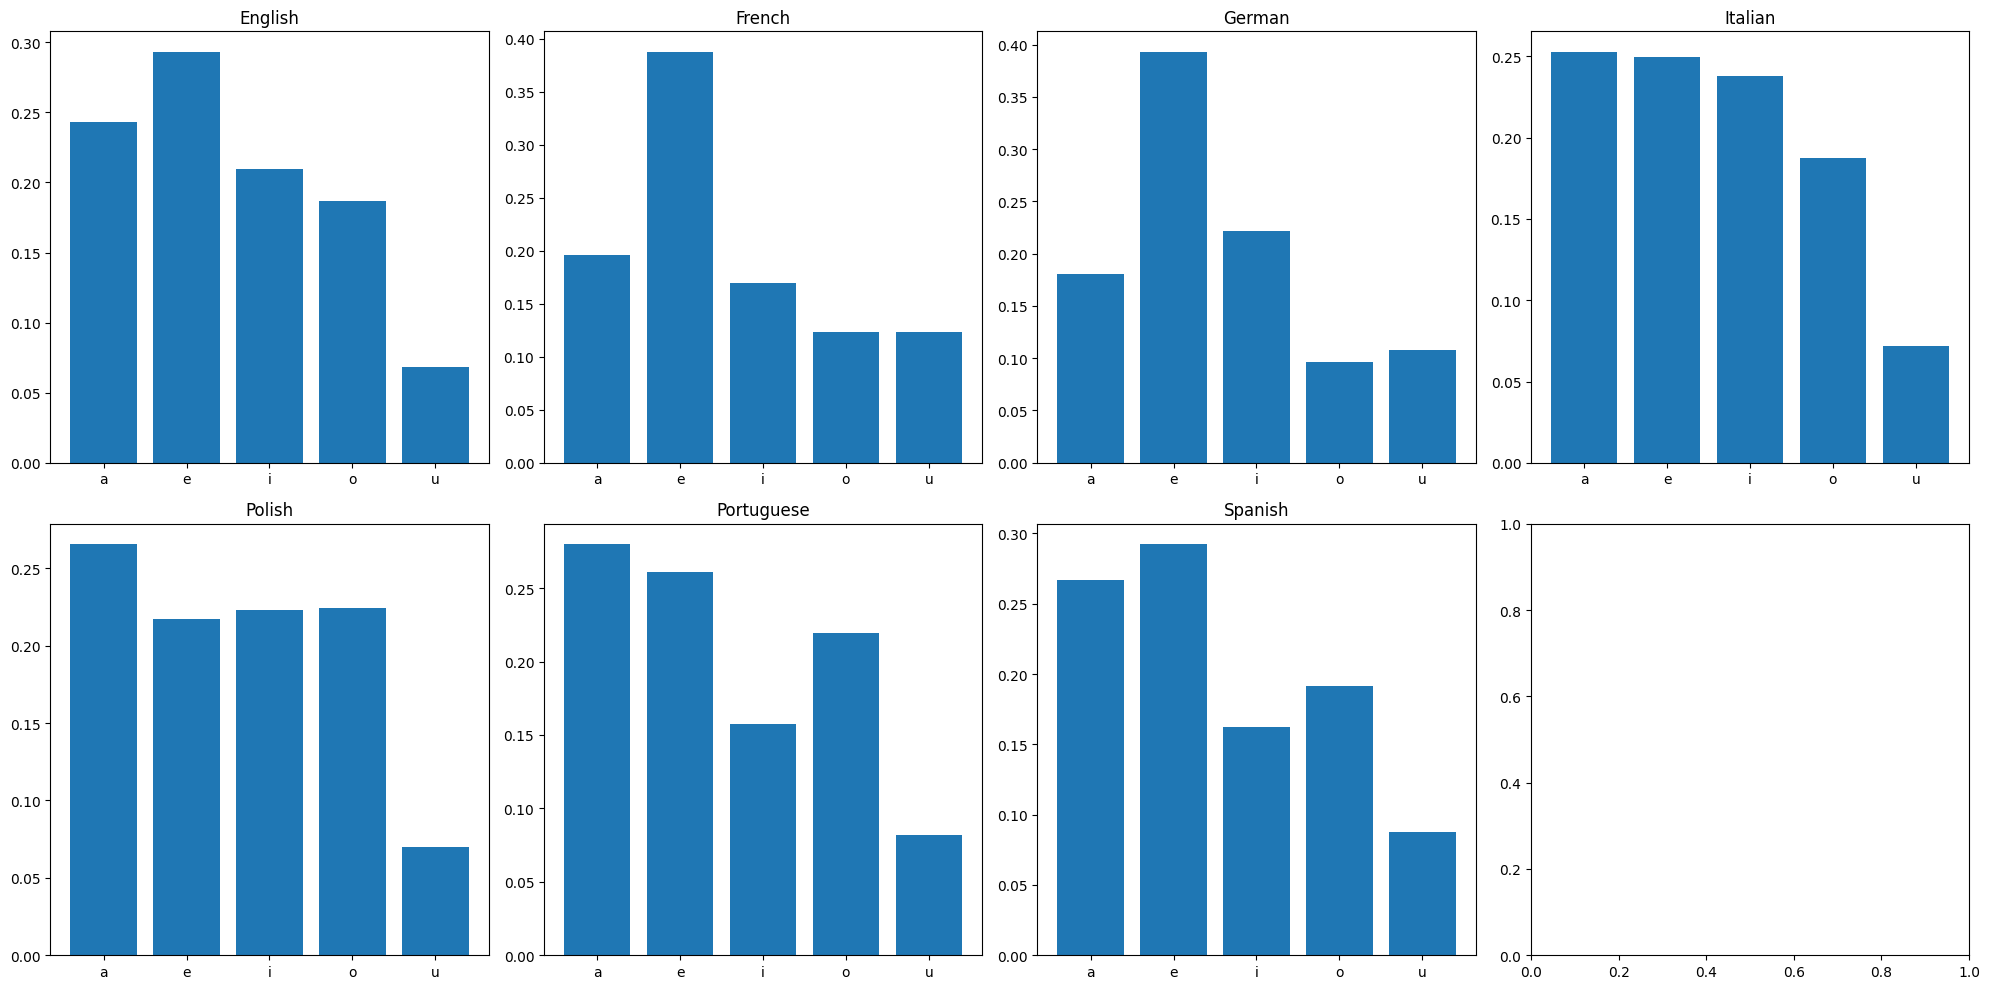

In [66]:
### НАЧАЛО РЕШЕНИЯ

# Гласные для анализа
vowels = 'aeiou'

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, lang in enumerate(languages):
    freqs = lang_to_probs[lang]
    vowel_freqs = {v: freqs.get(v, 0) for v in vowels}
    total = sum(vowel_freqs.values())
    ratios = {v: f/total for v, f in vowel_freqs.items()}
    
    axes.flatten()[i].bar(ratios.keys(), ratios.values())
    axes.flatten()[i].set_title(lang)

plt.tight_layout()
plt.show()

### КОНЕЦ РЕШЕНИЯ

## Правдоподобие (likelihood) (1+1=2 балла)

Давайте начнем имплементировать классификатор. Вначале недо написать мульиномиальную функцию правдоподобия. Напишите функцию `multinomial_likelihood(probs, freqs)`, которая принимает на вход два аргумента: `probs` - словарь вероятностей каждого символа (в некотором языке) и `freqs` - словарь абсолютных частот каждого символа (в некотором тексте, который мы хотим классифицировать). Эта функция должна возвращать вероятность получить такие абсолютные частоты из мультиномиального распределения - $P((X_1 = f_1) \cap (X_2 = f_2) \cap \ldots \cap (X_k = f_k))$, если $(X_1, \ldots, X_k)$ - система мультиномиальных случайных величин с вероятностями $(p_1, \ldots, p_k)$. (Вам понадобится функция `factorial`, которую можно импортировать из модуля `math`.)

In [67]:
### НАЧАЛО РЕШЕНИЯ
from math import factorial
from functools import reduce
import operator

def multinomial_likelihood(probs, freqs):
    n = sum(freqs.values())
    
    # Мультиномиальный коэффициент
    coefficient = factorial(n) / reduce(operator.mul, [factorial(f) for f in freqs.values()])
    
    # Произведение вероятностей
    product_probs = reduce(operator.mul, [probs.get(char, 0) ** freq for char, freq in freqs.items()])
    
    return coefficient * product_probs

### КОНЕЦ РЕШЕНИЯ

Давайте найдем вероятность получить следующий набор данных `{'a': 2, 'b': 1, 'c': 2}`из распределения `{'a': 0.2, 'b': 0.5, 'c': 0.3}`:

In [68]:
multinomial_likelihood(probs={'a': 0.2, 'b': 0.5, 'c': 0.3}, freqs={'a': 2, 'b': 1, 'c': 2})

0.05400000000000001

In [69]:
assert abs(multinomial_likelihood(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                    freqs={'a': 2, 'b': 1, 'c': 2}) - 0.054) < 0.000001
assert abs(multinomial_likelihood(probs={'a': 0.2, 'b': 0.1, 'c': 0.3, 'd': 0.4},
                    freqs={'a': 2, 'b': 1, 'c': 2}) - 0.0108) < 0.000001

Заметим, что коэффициент с факториалами зависит только от `freqs` (т.е. только от анализируемого текста) и не зависит от вероятностей `probs`. Это означает, что для любого языка этот коэффициент будет одни и тем же. Так как мы будем рассматривать конкретный текст и сравнивать его правдоподобие для разных языков, нам в большинстве случаев будет не нужен этот коэффициент. Напишите функцию `multinomial_likelihood_without_coeff`, которая будет возвращать те же вероятности, что и `multinomial_likelihood`, но без этого коэффициента.

In [70]:
### НАЧАЛО РЕШЕНИЯ
def multinomial_likelihood_without_coeff(probs, freqs):
    return reduce(operator.mul, [probs.get(char, 0) ** freq for char, freq in freqs.items()])
### КОНЕЦ РЕШЕНИЯ

Результат новой функции меньше по сравнению с результатом `multinomial_likelihood`:

In [71]:
multinomial_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                                     freqs={'a': 2, 'b': 1, 'c': 2})

0.0018000000000000004

In [72]:
assert multinomial_likelihood_without_coeff(
    probs={'a': 0.3, 'b': 0.4, 'c': 0.3},
    freqs={'a': 2, 'b': 1, 'c': 2}) == 0.00324
assert abs(multinomial_likelihood_without_coeff(
    probs={'a': 0.3, 'b': 0.4, 'c': 0.3},
    freqs={'a': 2, 'b': 1, 'c': 5}) - 8.747999999999e-05) < 1e-10

На самом деле результат работы `multinomial_likelihood_without_coeff` становится очень маленьким слишком быстро, когда мы увеличиваем абсолютные частоты в наших данных. Это не удивительно: вероятность получить в результате случайного эксперимента текст, который совпадает с нашим, очень мала.

In [73]:
multinomial_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                    freqs={'a': 3, 'b': 2, 'c': 2})

0.00018000000000000004

In [74]:
multinomial_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                    freqs={'a': 3, 'b': 20, 'c': 2})

6.866455078125001e-10

Из-за ограничений в точности вычислений у компьютера, мы довольно быстро начнем получать в точности ноль.

In [75]:
multinomial_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                                     freqs={'a': 543, 'b': 512, 'c': 2})

0.0

Таким образом, мы обычно не можем использовать правдоподобие напрямую. Обычный способ работы с такими маленькими числами — это использовать _логарифмы_ правдоводобия вместо самого правдоподобия. Действительно, логарифм — это монотонно возрастающая функция. Если мы сравниваем логарифмы, это эквивалентно сравнению их аргументов.